# DS-GS1011 nlp-Assignment 2  RNN/CNN-based Natural Language Inference

__Student Name:__ Wenting Qi

__Net ID:__ wq244

In [2]:
import os
import random
import string
import torch
import time
import pdb
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



In [3]:
cwd = os.getcwd()
print(cwd)
datadir = cwd+'/hw2_data'
os.chdir(datadir)

/home/wq244


In [10]:

pad_idx = 0
unk_idx = 1


def max_len(data):
    # get the maximum length of the two sentences, in order to save computing costs, we output seperate max_len for each sentence
    max_len = [max([len(sample[0]) for sample in data]), max([len(sample[1]) for sample in data])]

    return max_len


def convert_to_words(data):
    return [(sample[0].split(' '), sample[1].split(' '), sample[2]) for sample in data]

# convert the label to numerical classes
def convert_label(data):
    for sample in data:
        if sample[2] == 'contradiction':
            sample[2] = 0
        elif sample[2] == 'entailment':
            sample[2] = 1
        else:
            sample[2] = 2
    return data



def read_data():
    tsvfile1, tsvfile2 = open(datadir+'/snli_train.tsv'), open(datadir+'/snli_val.tsv')
    train_data = csv.reader(tsvfile1, delimiter='\t')
    val_data = csv.reader(tsvfile2, delimiter='\t')
    train_data, val_data = list(train_data), list(val_data)
    train_data, val_data = train_data[1:], val_data[1:]
    train_data, val_data = convert_label(train_data), convert_label(val_data)
    train_data, val_data = convert_to_words(train_data), convert_to_words(val_data)
    Max_len = max_len(train_data)
    tsvfile1.close()
    tsvfile2.close()
    return train_data, val_data, Max_len

def sep_genre(data):
    data_1,data_2,data_3,data_4,data_5=[],[],[],[],[]
    for x in data:
        if x[3] =='fiction':
            data_1.append(x[:-1])
        elif x[3] =='government':
            data_2.append(x[:-1])
        elif x[3] == 'slate':
            data_3.append(x[:-1])
        elif x[3] == 'telephone':
            data_4.append(x[:-1])
        elif x[3] == 'travel':
            data_5.append(x[:-1])
    return data_1, data_2, data_3, data_4, data_5


def read_data_multi():
    tsvfile1, tsvfile2 = open(datadir+'/mnli_train.tsv'), open(datadir+'/mnli_val.tsv')
    train_data = csv.reader(tsvfile1, delimiter='\t')
    val_data = csv.reader(tsvfile2, delimiter='\t')
    train_data, val_data = list(train_data), list(val_data)
    train_data, val_data = train_data[1:], val_data[1:]
    genre = [x[3] for x in val_data]
    train_data_1, train_data_2, train_data_3, train_data_4, train_data_5 = sep_genre(train_data)
    val_data_1, val_data_2, val_data_3, val_data_4, val_data_5 = sep_genre(val_data)
    
    train_data_1, val_data_1 = convert_label(train_data_1), convert_label(val_data_1)
    train_data_2, val_data_2 = convert_label(train_data_2), convert_label(val_data_2)
    train_data_3, val_data_3 = convert_label(train_data_3), convert_label(val_data_3)
    train_data_4, val_data_4 = convert_label(train_data_4), convert_label(val_data_4)
    train_data_5, val_data_5 = convert_label(train_data_5), convert_label(val_data_5)
    
    train_data_1, val_data_1 = convert_to_words(train_data_1), convert_to_words(val_data_1)
    train_data_2, val_data_2 = convert_to_words(train_data_2), convert_to_words(val_data_2)
    train_data_3, val_data_3 = convert_to_words(train_data_3), convert_to_words(val_data_3)
    train_data_4, val_data_4 = convert_to_words(train_data_4), convert_to_words(val_data_4)
    train_data_5, val_data_5 = convert_to_words(train_data_5), convert_to_words(val_data_5)
    max_len_1, max_len_2, max_len_3, max_len_4, max_len_5 = max_len(train_data_1), max_len(train_data_2), max_len(train_data_3), max_len(train_data_4), max_len(train_data_5)
    tsvfile1.close()
    tsvfile2.close()
    return train_data_1, train_data_2, train_data_3, train_data_4, train_data_5, val_data_1, val_data_2, val_data_3, val_data_4, val_data_5 ,max_len_1, max_len_2, max_len_3, max_len_4, max_len_5

In [11]:
train_data, val_data, MAX_SENTENCE_LENGTH = read_data()

In [12]:
train_data_1, train_data_2, train_data_3, train_data_4, train_data_5, val_data_1, val_data_2, val_data_3, val_data_4, val_data_5 ,max_len_1, max_len_2, max_len_3, max_len_4, max_len_5 = read_data_multi()

In [13]:
# loading the Fasttext word vectors sets from wikipedia news, the vocab size would be 50000
words_to_load = 50000
# generate random vectors for pad and out-of-vocab words
pad = np.random.uniform(low=-1, high=1, size=(300,))
unk = np.random.uniform(low=-1, high=1, size=(300,))

with open('wiki-news-300d-1M.vec') as f:
    id2emb = np.zeros((words_to_load+2, 300))
    id2emb[0], id2emb[1] = pad, unk
    word2id = {'<pad>': pad_idx,'<unk>': unk_idx}
    vocab = ['<pad>','<unk>']
    for i, line in enumerate(f,start=1):
        if i >= words_to_load: 
            break
        if i>1:
            s = line.split()
            id2emb[i, :] = np.asarray(s[1:])
            word2id[s[0]] = i
            vocab.append(s[0])

In [14]:
class VocabDataset(Dataset):

    def __init__(self, data_tuple, word2id):
        self.s1_list, self.s2_list, self.target_list = zip(*data_tuple)
        assert (len(self.s1_list) == len(self.target_list)) and (len(self.s2_list) == len(self.target_list))
        self.word2id = word2id

    def __len__(self):
        return len(self.s1_list)

    def __getitem__(self, key):
        # convert word token into indices
        s1word_idx = [self.word2id[c] if c in self.word2id.keys() else unk_idx  for c in self.s1_list[key][:MAX_SENTENCE_LENGTH[0]]]
        s2word_idx = [self.word2id[c] if c in self.word2id.keys() else unk_idx  for c in self.s2_list[key][:MAX_SENTENCE_LENGTH[1]]]
        label = self.target_list[key]
        return [s1word_idx, s2word_idx, len(s1word_idx), len(s2word_idx), label]

def vocab_collate_func(batch):

    s1_data_list = []
    s2_data_list = []
    label_list = []
    s1_length_list = []
    s2_length_list = []

    for datum in batch:
        label_list.append(datum[4])
        s1_length_list.append(datum[2])
        s2_length_list.append(datum[3])
    # padding
    for datum in batch:
        s1_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH[0]-datum[2])),
                                mode="constant", constant_values=0)
        s2_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH[1]-datum[3])),
                                mode="constant", constant_values=0)
        s1_data_list.append(s1_padded_vec)
        s2_data_list.append(s2_padded_vec)
    # sort in descending length according to s1
    ind_dec_order = np.argsort(s1_length_list)[::-1]
    s1_data_list = np.array(s1_data_list)[ind_dec_order]
    s2_data_list = np.array(s2_data_list)[ind_dec_order]
    s1_length_list = np.array(s1_length_list)[ind_dec_order]
    s2_length_list = np.array(s2_length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(s1_data_list)), torch.from_numpy(np.array(s2_data_list)), torch.LongTensor(s1_length_list), torch.LongTensor(s2_length_list), torch.LongTensor(label_list).to(device)]



In [15]:
BATCH_SIZE = 128

In [16]:
# Build train, valid and test dataloaders

train_dataset = VocabDataset(train_data, word2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_data, word2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)



In [17]:
val_dataset_1 = VocabDataset(val_data_1, word2id)
val_loader_1 = torch.utils.data.DataLoader(dataset=val_dataset_1,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
val_dataset_2 = VocabDataset(val_data_2, word2id)
val_loader_2 = torch.utils.data.DataLoader(dataset=val_dataset_2,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
val_dataset_3 = VocabDataset(val_data_3, word2id)
val_loader_3 = torch.utils.data.DataLoader(dataset=val_dataset_3,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
val_dataset_4 = VocabDataset(val_data_4, word2id)
val_loader_4 = torch.utils.data.DataLoader(dataset=val_dataset_4,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
val_dataset_5 = VocabDataset(val_data_5, word2id)
val_loader_5 = torch.utils.data.DataLoader(dataset=val_dataset_5,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [18]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

## RNN Model

### Model I

In [37]:
class RNN(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, vocab_size):
        super(RNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.rnn = nn.GRU(300,hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*4, hidden_size*4)
        self.linear2 = nn.Linear(hidden_size*4, num_classes) 



    def forward(self, s1, s2, s1_lengths, s2_lengths):
        batch_size_1, seq_len_1 = s1.size()
        batch_size_2, seq_len_2, = s2.size()
        hidden1 = torch.zeros(self.num_layers*2, batch_size_1, self.hidden_size).to(device)
        # embedding word tokens using the loaded vector sets
        s1_embed = np.zeros((batch_size_1, seq_len_1,300))
        for row, i in enumerate(s1):           
            for col, j in enumerate(i):
                s1_embed[row][col]=np.asarray(id2emb[j])
        s1_embed = torch.FloatTensor(s1_embed).to(device)

        s1_embed = torch.nn.utils.rnn.pack_padded_sequence(s1_embed, s1_lengths.numpy(), batch_first=True)
        s1_rnn_out, self.hidden_1 = self.rnn(s1_embed.to(device), hidden1)
        s1_rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(s1_rnn_out.to(device), batch_first=True)
        # hidden representation of sentence 1
        s1_rnn_out = torch.sum(s1_rnn_out, dim=1).to(device)

        

        # embedding s2
        s2_embed = np.zeros((batch_size_2, seq_len_2, 300))
        for row, i in enumerate(s2):
            for col, j in enumerate(i):
                s2_embed[row][col]=np.asarray(id2emb[j[0]])
        s2_lengths = torch.Tensor.numpy(s2_lengths)
        # sort sentence 2 accroding to its length
        ind_dec_order_s2 = np.argsort(s2_lengths)[::-1]
        rev_ind = np.argsort(ind_dec_order_s2)
        s2_embed = np.array(s2_embed)[ind_dec_order_s2]
        s2_lengths = np.array(s2_lengths)[ind_dec_order_s2]
        s2_embed = torch.FloatTensor(s2_embed).to(device)
        hidden2 = torch.zeros(self.num_layers*2, batch_size_2, self.hidden_size).to(device)
        s2_embed = torch.nn.utils.rnn.pack_padded_sequence(s2_embed, s2_lengths, batch_first=True)
        s2_rnn_out, self.hidden_2 = self.rnn(s2_embed.to(device), hidden2)
        s2_rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(s2_rnn_out, batch_first=True)
        # reverse the sorting to match sentence 1
        s2_rnn_out = s2_rnn_out[rev_ind]
        # hidden representation of sentence 2
        s2_rnn_out = torch.sum(s2_rnn_out.to(device), dim=1)
        # concat the two representations
        rnn_out = torch.cat((s1_rnn_out, s2_rnn_out), 1).to(device)
        out = self.linear1(rnn_out)
        logits = self.linear2(out.to(device))
        return logits





In [39]:
t0 = time.time()
val_acc_epochs_biRNN_100 = []
train_loss_RNN_100 = []
val_loss_RNN_100 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    running_loss = 0
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels)

        running_loss += loss.item()       

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    val_loss = running_loss/len(loader)
    return (100 * correct / total), val_loss

model = RNN(hidden_size=100, num_layers=1, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_epochs_biRNN_100.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_loss_RNN_100.append(val_loss)        
    train_loss = running_loss/total_step
    train_loss_RNN_100.append(train_loss)
    print('Training Loss: {}, Validation Loss: {}'.format(train_loss, val_loss))
    

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

number of parameters:402803


/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 51.2
Epoch: [1/5], Step: [201/782], Validation Acc: 52.6
Epoch: [1/5], Step: [301/782], Validation Acc: 53.5
Epoch: [1/5], Step: [401/782], Validation Acc: 57.3
Epoch: [1/5], Step: [501/782], Validation Acc: 56.7
Epoch: [1/5], Step: [601/782], Validation Acc: 58.2
Epoch: [1/5], Step: [701/782], Validation Acc: 57.8
Training Loss: 0.947859250218667, Validation Loss: 0.9919396787881851
Epoch: [2/5], Step: [101/782], Validation Acc: 58.9
Epoch: [2/5], Step: [201/782], Validation Acc: 59.4
Epoch: [2/5], Step: [301/782], Validation Acc: 58.6
Epoch: [2/5], Step: [401/782], Validation Acc: 57.9
Epoch: [2/5], Step: [501/782], Validation Acc: 59.7
Epoch: [2/5], Step: [601/782], Validation Acc: 59.7
Epoch: [2/5], Step: [701/782], Validation Acc: 61.4
Training Loss: 0.8838316390429006, Validation Loss: 0.9710007607936859
Epoch: [3/5], Step: [101/782], Validation Acc: 59.5
Epoch: [3/5], Step: [201/782], Validation Acc: 59.6
Epoch: [3/5], Step: [301/78

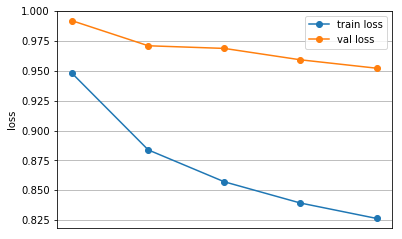

In [44]:
train=plt.plot(train_loss_RNN_100, marker='o', label='train loss')
val=plt.plot(val_loss_RNN_100, marker='o', label='val loss')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('loss')

### Model II

In [40]:
t0 = time.time()
val_acc_epochs_biRNN_300 = []
train_loss_RNN_300 = []
val_loss_RNN_300 = []



model = RNN(hidden_size=300, num_layers=1, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_epochs_biRNN_300.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_loss_RNN_300.append(val_loss)        
    train_loss = running_loss/total_step
    train_loss_RNN_300.append(train_loss)
    print('Training Loss: {}, Validation Loss: {}'.format(train_loss, val_loss))
    

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

number of parameters:2528403


/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 52.8
Epoch: [1/5], Step: [201/782], Validation Acc: 54.7
Epoch: [1/5], Step: [301/782], Validation Acc: 56.0
Epoch: [1/5], Step: [401/782], Validation Acc: 56.0
Epoch: [1/5], Step: [501/782], Validation Acc: 54.5
Epoch: [1/5], Step: [601/782], Validation Acc: 57.3
Epoch: [1/5], Step: [701/782], Validation Acc: 58.7
Training Loss: 0.9344447944170374, Validation Loss: 0.9822770580649376
Epoch: [2/5], Step: [101/782], Validation Acc: 59.0
Epoch: [2/5], Step: [201/782], Validation Acc: 59.3
Epoch: [2/5], Step: [301/782], Validation Acc: 59.2
Epoch: [2/5], Step: [401/782], Validation Acc: 60.5
Epoch: [2/5], Step: [501/782], Validation Acc: 60.6
Epoch: [2/5], Step: [601/782], Validation Acc: 60.5
Epoch: [2/5], Step: [701/782], Validation Acc: 61.0
Training Loss: 0.8703551333578651, Validation Loss: 0.9772488176822662
Epoch: [3/5], Step: [101/782], Validation Acc: 60.8
Epoch: [3/5], Step: [201/782], Validation Acc: 61.5
Epoch: [3/5], Step: [301/7

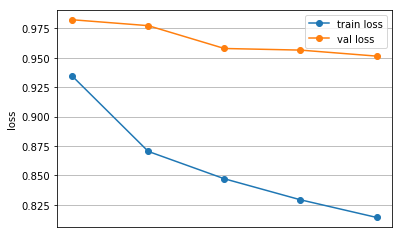

In [45]:
train=plt.plot(train_loss_RNN_300, marker='o', label='train loss')
val=plt.plot(val_loss_RNN_300, marker='o', label='val loss')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('loss')

### Model III

In [41]:
t0 = time.time()
val_acc_epochs_biRNN_500 = []
train_loss_RNN_500 = []
val_loss_RNN_500 = []



model = RNN(hidden_size=500, num_layers=1, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_epochs_biRNN_500.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_loss_RNN_500.append(val_loss)        
    train_loss = running_loss/total_step
    train_loss_RNN_500.append(train_loss)
    print('Training Loss: {}, Validation Loss: {}'.format(train_loss, val_loss))
    

t1 = time.time()
print ('Time elapse:{}'.format(t1-t0))

number of parameters:6414003


/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 54.6
Epoch: [1/5], Step: [201/782], Validation Acc: 54.6
Epoch: [1/5], Step: [301/782], Validation Acc: 57.4
Epoch: [1/5], Step: [401/782], Validation Acc: 55.7
Epoch: [1/5], Step: [501/782], Validation Acc: 59.1
Epoch: [1/5], Step: [601/782], Validation Acc: 59.5
Epoch: [1/5], Step: [701/782], Validation Acc: 58.6
Training Loss: 0.9395544616615071, Validation Loss: 0.9867498427629471
Epoch: [2/5], Step: [101/782], Validation Acc: 60.6
Epoch: [2/5], Step: [201/782], Validation Acc: 59.0
Epoch: [2/5], Step: [301/782], Validation Acc: 59.6
Epoch: [2/5], Step: [401/782], Validation Acc: 58.4
Epoch: [2/5], Step: [501/782], Validation Acc: 60.8
Epoch: [2/5], Step: [601/782], Validation Acc: 59.5
Epoch: [2/5], Step: [701/782], Validation Acc: 60.7
Training Loss: 0.8703780512675605, Validation Loss: 0.9681735932826996
Epoch: [3/5], Step: [101/782], Validation Acc: 61.0
Epoch: [3/5], Step: [201/782], Validation Acc: 60.1
Epoch: [3/5], Step: [301/7

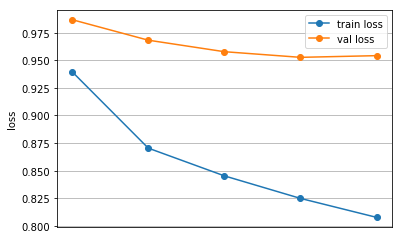

In [46]:
train=plt.plot(train_loss_RNN_500, marker='o', label='train loss')
val=plt.plot(val_loss_RNN_500, marker='o', label='val loss')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('loss')

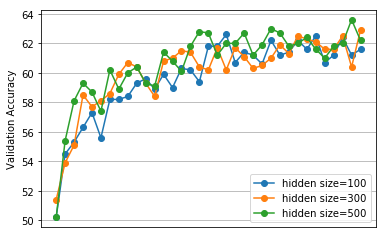

In [75]:
%matplotlib inline


hs_1=plt.plot(val_acc_epochs_biRNN_100, marker='o', label='hidden size=100')
hs_3=plt.plot(val_acc_epochs_biRNN_300, marker='o', label='hidden size=300')
hs_5=plt.plot(val_acc_epochs_biRNN_500, marker='o', label='hidden size=500')

plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')


### Model IV

In [42]:
class RNN_mul(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, vocab_size):
        super(RNN_mul, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.rnn = nn.GRU(300,hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes) 



    def forward(self, s1, s2, s1_lengths, s2_lengths):
        batch_size_1, seq_len_1 = s1.size()
        
        batch_size_2, seq_len_2, = s2.size()
        hidden1 = torch.zeros(self.num_layers*2, batch_size_1, self.hidden_size).to(device)
        s1_embed = np.zeros((batch_size_1, seq_len_1,300))
        for row, i in enumerate(s1):           
            for col, j in enumerate(i):
                s1_embed[row][col]=np.asarray(id2emb[j])
        s1_embed = torch.FloatTensor(s1_embed).to(device)
        s1_embed = torch.nn.utils.rnn.pack_padded_sequence(s1_embed, s1_lengths.numpy(), batch_first=True)
        s1_rnn_out, self.hidden_1 = self.rnn(s1_embed.to(device), hidden1)
        s1_rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(s1_rnn_out.to(device), batch_first=True)
        s1_rnn_out = torch.sum(s1_rnn_out, dim=1).to(device)
        

        s2_embed = np.zeros((batch_size_2, seq_len_2, 300))
        for row, i in enumerate(s2):
            for col, j in enumerate(i):
                s2_embed[row][col]=np.asarray(id2emb[j[0]])
        s2_lengths = torch.Tensor.numpy(s2_lengths)
        ind_dec_order_s2 = np.argsort(s2_lengths)[::-1]
        rev_ind = np.argsort(ind_dec_order_s2)
        
        s2_embed = np.array(s2_embed)[ind_dec_order_s2]
        s2_lengths = np.array(s2_lengths)[ind_dec_order_s2]
        s2_embed = torch.FloatTensor(s2_embed).to(device)
        hidden2 = torch.zeros(self.num_layers*2, batch_size_2, self.hidden_size).to(device)
        s2_embed = torch.nn.utils.rnn.pack_padded_sequence(s2_embed, s2_lengths, batch_first=True)
        s2_rnn_out, self.hidden_2 = self.rnn(s2_embed.to(device), hidden2)
        s2_rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(s2_rnn_out, batch_first=True)
        
        s2_rnn_out = s2_rnn_out[rev_ind]
        s2_rnn_out = torch.sum(s2_rnn_out.to(device), dim=1)
        rnn_out = torch.mul(s1_rnn_out, s2_rnn_out).to(device)
        out = self.linear1(rnn_out)
        logits = self.linear2(out.to(device))
        return logits





In [43]:
t0 = time.time()
val_acc_epochs_RNNmul_500 = []
train_loss_RNNmul_500 = []
val_loss_RNNmul_500 = []



model = RNN_mul(hidden_size=500, num_layers=1, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_epochs_RNNmul_500.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_loss_RNNmul_500.append(val_loss)        
    train_loss = running_loss/total_step
    train_loss_RNNmul_500.append(train_loss)
    print('Training Loss: {}, Validation Loss: {}'.format(train_loss, val_loss))
    

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

number of parameters:3410003


/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 46.7
Epoch: [1/5], Step: [201/782], Validation Acc: 50.8
Epoch: [1/5], Step: [301/782], Validation Acc: 52.1
Epoch: [1/5], Step: [401/782], Validation Acc: 58.3
Epoch: [1/5], Step: [501/782], Validation Acc: 60.2
Epoch: [1/5], Step: [601/782], Validation Acc: 60.4
Epoch: [1/5], Step: [701/782], Validation Acc: 58.5
Training Loss: 0.9750649286505512, Validation Loss: 0.9816606566309929
Epoch: [2/5], Step: [101/782], Validation Acc: 60.7
Epoch: [2/5], Step: [201/782], Validation Acc: 61.5
Epoch: [2/5], Step: [301/782], Validation Acc: 63.3
Epoch: [2/5], Step: [401/782], Validation Acc: 63.1
Epoch: [2/5], Step: [501/782], Validation Acc: 61.7
Epoch: [2/5], Step: [601/782], Validation Acc: 62.7
Epoch: [2/5], Step: [701/782], Validation Acc: 63.3
Training Loss: 0.8369880580078916, Validation Loss: 0.9449402317404747
Epoch: [3/5], Step: [101/782], Validation Acc: 62.1
Epoch: [3/5], Step: [201/782], Validation Acc: 67.0
Epoch: [3/5], Step: [301/7

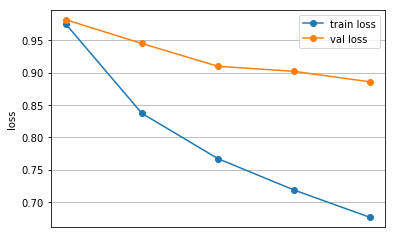

In [47]:
train=plt.plot(train_loss_RNNmul_500, marker='o', label='train loss')
val=plt.plot(val_loss_RNNmul_500, marker='o', label='val loss')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('loss')

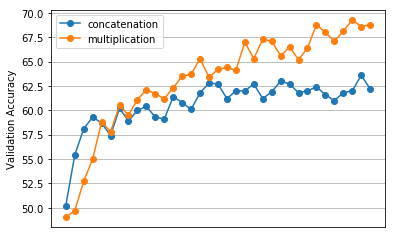

In [225]:

concat=plt.plot(val_acc_epochs_biRNN_500, marker='o', label='concatenation')
mul=plt.plot(val_acc_epochs_RNNmul_500, marker='o', label='multiplication')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')


In [230]:
def three_correct_perdict(loader, model):
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        i = 0
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correct = list(predicted.eq(labels.view_as(predicted)))
        s1_indices_data = list(s1_batch)
        s1_string = []
    
        for x in s1_indices_data:
            sentence = []
            for y in x:
                y = int(y)
                sentence.append(vocab[y])
            s1_string.append(sentence)
        s2_indices_data = list(s2_batch)
        s2_string = []
        for x in s2_indices_data:
            sentence = []
            for y in x:
                y = int(y)
                sentence.append(vocab[y])
            s2_string.append(sentence)
            
        label_target = list(label_batch)
        while correct[i] == 1:
            print('s1: {}, s2: {},  Label: {}, Predicted: {}'.format(s1_string[i], s2_string[i] ,label_target[i],predicted[i]))
            total += 1
            if total == 3:
                break
            i += 1
    return 

In [231]:
three_correct_perdict(val_loader, model)

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


s1: ['A', 'young', 'girl', 'with', 'blue', 'and', 'pink', 'ribbons', 'in', 'her', '<unk>', ',', 'without', 'a', 'top', 'and', 'a', 'woman', 'with', 'a', 'white', 't-shirt', 'and', 'a', 'zebra', 'skirt', 'wading', 'in', 'a', 'public', 'water', 'fountain', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], s2: ['A', 'young', 'girl', '<unk>', 'a', 'sweater', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

In [232]:
def three_incorrect_perdict(loader, model):
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        i = 0
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correct = list(predicted.eq(labels.view_as(predicted)))
        s1_indices_data = list(s1_batch)
        s1_string = []
    
        for x in s1_indices_data:
            sentence = []
            for y in x:
                y = int(y)
                sentence.append(vocab[y])
            s1_string.append(sentence)
        s2_indices_data = list(s2_batch)
        s2_string = []
        for x in s2_indices_data:
            sentence = []
            for y in x:
                y = int(y)
                sentence.append(vocab[y])
            s2_string.append(sentence)
            
        label_target = list(label_batch)
        while correct[i] != 1:
            print('s1: {}, s2: {},  Label: {}, Predicted: {}'.format(s1_string[i], s2_string[i] ,label_target[i],predicted[i]))
            total += 1
            if total == 3:
                break
            i += 1
    return 

In [233]:
three_incorrect_perdict(val_loader, model)

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


s1: ['A', 'man', 'in', 'a', 'brown', 'jacket', ',', 'white', 'shirt', ',', 'and', 'dark', '<unk>', 'is', 'holding', 'a', 'book', 'with', 'his', 'finger', 'on', 'the', 'page', 'while', 'sitting', 'on', 'a', 'wooden', 'floor', ',', 'and', 'leaning', 'against', 'a', 'yellow', 'wall', 'with', 'a', 'door', 'on', 'one', 'side', 'and', 'cloths', 'on', '<unk>', 'on', 'the', 'other', 'side', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], s2: ['A', 'man', 'sits', 'on', 'a', 'wooden', 'floor', 'building', 'a', 'model', 'ship', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [217]:
# validation on MNLI task
RNN_1_val_acc = test_model(val_loader_1, model)
RNN_2_val_acc = test_model(val_loader_2, model)
RNN_3_val_acc = test_model(val_loader_3, model)
RNN_4_val_acc = test_model(val_loader_4, model)
RNN_5_val_acc = test_model(val_loader_5, model)
print('fiction:{}, government:{}, slate:{}, telephone:{}, travel:{}'.format(RNN_1_val_acc, RNN_2_val_acc, RNN_3_val_acc, RNN_4_val_acc, RNN_5_val_acc))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


fiction:45.12562814070352, government:43.20866141732284, slate:41.417165668662676, telephone:43.98009950248756, travel:43.58452138492871


## CNN Model

### Model V

In [19]:
class CNN(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        # self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        # kernal size serve as the no. of works to bag together
        self.conv1 = nn.Conv1d(300, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool1d(kernel_size=20, stride=1)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)

    def forward(self, s1, s2, s1_lengths, s2_lengths):
        batch_size_1, seq_len_1 = s1.size()
        batch_size_2, seq_len_2 = s2.size()

        s1_embed = np.zeros((batch_size_1, seq_len_1, 300))
        for row, i in enumerate(s1):
            for col, j in enumerate(i):
                s1_embed[row][col]=np.asarray(id2emb[j])
        s1_embed = torch.FloatTensor(s1_embed).to(device)
        # embed = self.embedding(x)
        s1_hidden = self.conv1(s1_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))

        s1_hidden = self.conv2(s1_hidden.transpose(1,2).to(device)).transpose(1,2)
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))
        #s1_hidden = torch.sum(s1_hidden, dim=1)
        
        s1_cnn_out = self.pool(s1_hidden.transpose(1,2).to(device))
        s1_cnn_out = torch.sum(s1_cnn_out.transpose(1,2), dim=1).to(device)
        
        s2_embed = np.zeros((batch_size_2, seq_len_2, 300))
        for row, i in enumerate(s2):
            for col, j in enumerate(i):
                s2_embed[row][col]=np.asarray(id2emb[j[0]])
        s2_embed = torch.FloatTensor(s2_embed).to(device)
        s2_hidden = self.conv1(s2_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))

        s2_hidden = self.conv2(s2_hidden.transpose(1,2).to(device)).transpose(1,2)
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))
        
        s2_cnn_out = self.pool(s2_hidden.transpose(1,2).to(device))
        s2_cnn_out = torch.sum(s2_cnn_out.transpose(1,2), dim=1).to(device)
        
        cnn_out = torch.cat((s1_cnn_out, s2_cnn_out), 1)
        out = self.linear1(cnn_out.to(device))
        logits = self.linear2(out.to(device))
        return logits

In [21]:
t0 = time.time()
val_acc_epochs_CNN_100 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(hidden_size=100, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))

learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_epochs_CNN_100.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 36.2
Epoch: [1/5], Step: [201/782], Validation Acc: 47.3
Epoch: [1/5], Step: [301/782], Validation Acc: 55.8
Epoch: [1/5], Step: [401/782], Validation Acc: 56.2
Epoch: [1/5], Step: [501/782], Validation Acc: 57.5
Epoch: [1/5], Step: [601/782], Validation Acc: 58.0
Epoch: [1/5], Step: [701/782], Validation Acc: 57.6
Epoch: [2/5], Step: [101/782], Validation Acc: 60.5
Epoch: [2/5], Step: [201/782], Validation Acc: 59.3
Epoch: [2/5], Step: [301/782], Validation Acc: 60.5
Epoch: [2/5], Step: [401/782], Validation Acc: 59.3
Epoch: [2/5], Step: [501/782], Validation Acc: 60.1
Epoch: [2/5], Step: [601/782], Validation Acc: 60.3
Epoch: [2/5], Step: [701/782], Validation Acc: 60.8
Epoch: [3/5], Step: [101/782], Validation Acc: 61.5
Epoch: [3/5], Step: [201/782], Validation Acc: 60.7
Epoch: [3/5], Step: [301/782], Validation Acc: 61.5
Epoch: [3/5], Step: [401/782], Validation Acc: 61.4
Epoch: [3/5], Step: [501/782], Validation Acc: 60.3
Epoch: [3/5]

### Model VI

In [22]:
t0 = time.time()
val_acc_epochs_CNN_300 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(hidden_size=300, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_epochs_CNN_300.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 44.0
Epoch: [1/5], Step: [201/782], Validation Acc: 52.5
Epoch: [1/5], Step: [301/782], Validation Acc: 55.2
Epoch: [1/5], Step: [401/782], Validation Acc: 56.4
Epoch: [1/5], Step: [501/782], Validation Acc: 58.4
Epoch: [1/5], Step: [601/782], Validation Acc: 59.3
Epoch: [1/5], Step: [701/782], Validation Acc: 59.7
Epoch: [2/5], Step: [101/782], Validation Acc: 61.5
Epoch: [2/5], Step: [201/782], Validation Acc: 62.2
Epoch: [2/5], Step: [301/782], Validation Acc: 61.0
Epoch: [2/5], Step: [401/782], Validation Acc: 61.8
Epoch: [2/5], Step: [501/782], Validation Acc: 60.1
Epoch: [2/5], Step: [601/782], Validation Acc: 62.4
Epoch: [2/5], Step: [701/782], Validation Acc: 62.3
Epoch: [3/5], Step: [101/782], Validation Acc: 61.8
Epoch: [3/5], Step: [201/782], Validation Acc: 63.9
Epoch: [3/5], Step: [301/782], Validation Acc: 63.6
Epoch: [3/5], Step: [401/782], Validation Acc: 64.4
Epoch: [3/5], Step: [501/782], Validation Acc: 62.5
Epoch: [3/5]

### Model VII

In [ ]:
t0 = time.time()
val_acc_epochs_CNN_500 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN(hidden_size=500, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_epochs_CNN_500.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
parameters = list(model.parameters())
print(len(parameters))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

### Model VIII

In [ ]:
t0 = time.time()
val_acc_epochs_CNN_1000 = []
val_loss_CNN_1000 = []
train_loss_CNN_1000 =[]
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    running_loss = 0
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels)

        running_loss += loss.item()       

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    val_loss = running_loss/len(loader)
    return (100 * correct / total), val_loss


model = CNN(hidden_size=1000, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_epochs_CNN_1000.append(val_acc)
            
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    val_loss_CNN_1000.append(val_loss)        
    train_loss = running_loss/total_step
    train_loss_CNN_1000.append(train_loss)
    print('Training Loss: {}, Validation Loss: {}'.format(train_loss, val_loss))
    

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

number of parameters:7910003


/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 34.9
Epoch: [1/5], Step: [201/782], Validation Acc: 46.9


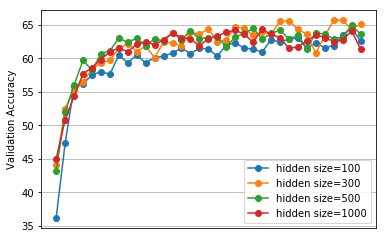

In [26]:
%matplotlib inline
hs_1=plt.plot(val_acc_epochs_CNN_100, marker='o', label='hidden size=100')
hs_3=plt.plot(val_acc_epochs_CNN_300, marker='o', label='hidden size=300')
hs_5=plt.plot(val_acc_epochs_CNN_500, marker='o', label='hidden size=500')
hs_10=plt.plot(val_acc_epochs_CNN_1000, marker='o', label='hidden size=1000')


plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')


In [237]:
three_correct_perdict(val_loader, model)

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


s1: ['A', 'man', 'in', 'a', 'brown', 'jacket', ',', 'white', 'shirt', ',', 'and', 'dark', '<unk>', 'is', 'holding', 'a', 'book', 'with', 'his', 'finger', 'on', 'the', 'page', 'while', 'sitting', 'on', 'a', 'wooden', 'floor', ',', 'and', 'leaning', 'against', 'a', 'yellow', 'wall', 'with', 'a', 'door', 'on', 'one', 'side', 'and', 'cloths', 'on', '<unk>', 'on', 'the', 'other', 'side', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], s2: ['A', 'man', 'sits', 'on', 'a', 'wooden', 'floor', 'building', 'a', 'model', 'ship', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [238]:
three_incorrect_perdict(val_loader, model)

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


s1: ['A', '<unk>', 'woman', 'in', 'a', 'blue', 'top', 'and', 'black', '<unk>', 'looks', 'off', 'to', 'the', 'side', 'of', 'the', 'camera', 'with', 'a', 'drink', 'in', 'one', 'hand', 'and', 'a', 'amused', 'look', 'upon', 'her', 'face', ',', 'while', 'a', 'man', 'sits', 'next', 'to', 'her', ',', 'looking', '<unk>', ',', 'drink', 'in', 'one', 'hand', ',', 'straw', 'in', 'the', 'other', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], s2: ['A', 'man', 'and', 'woman', 'are', 'having', 'drinks', 'in', 'a', 'bar', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

In [222]:
# validation on MNLI task
CNN_1_val_acc = test_model(val_loader_1, model)
CNN_2_val_acc = test_model(val_loader_2, model)
CNN_3_val_acc = test_model(val_loader_3, model)
CNN_4_val_acc = test_model(val_loader_4, model)
CNN_5_val_acc = test_model(val_loader_5, model)
print('fiction:{}, government:{}, slate:{}, telephone:{}, travel:{}'.format(CNN_1_val_acc, CNN_2_val_acc, CNN_3_val_acc, CNN_4_val_acc, CNN_5_val_acc))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


fiction:42.21105527638191, government:39.56692913385827, slate:39.920159680638726, telephone:41.492537313432834, travel:41.24236252545825


### Model IX

In [52]:
class CNN_5(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN_5, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        # self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        # kernal size serve as the no. of works to bag together
        self.conv1 = nn.Conv1d(300, hidden_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.pool = torch.nn.MaxPool1d(kernel_size=20, stride=1)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)

    def forward(self, s1, s2, s1_lengths, s2_lengths):
        batch_size_1, seq_len_1 = s1.size()
        batch_size_2, seq_len_2 = s2.size()

        s1_embed = np.zeros((batch_size_1, seq_len_1, 300))
        for row, i in enumerate(s1):
            for col, j in enumerate(i):
                s1_embed[row][col]=np.asarray(id2emb[j])
        s1_embed = torch.FloatTensor(s1_embed).to(device)
        # embed = self.embedding(x)
        s1_hidden = self.conv1(s1_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))

        s1_hidden = self.conv2(s1_hidden.transpose(1,2).to(device)).transpose(1,2)
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))
        #s1_hidden = torch.sum(s1_hidden, dim=1)
        
        s1_cnn_out = self.pool(s1_hidden.transpose(1,2).to(device))
        s1_cnn_out = torch.sum(s1_cnn_out.transpose(1,2), dim=1).to(device)
        
        s2_embed = np.zeros((batch_size_2, seq_len_2, 300))
        for row, i in enumerate(s2):
            for col, j in enumerate(i):
                s2_embed[row][col]=np.asarray(id2emb[j[0]])
        s2_embed = torch.FloatTensor(s2_embed).to(device)
        s2_hidden = self.conv1(s2_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))

        s2_hidden = self.conv2(s2_hidden.transpose(1,2).to(device)).transpose(1,2)
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))
        
        s2_cnn_out = self.pool(s2_hidden.transpose(1,2).to(device))
        s2_cnn_out = torch.sum(s2_cnn_out.transpose(1,2), dim=1).to(device)
        
        cnn_out = torch.cat((s1_cnn_out, s2_cnn_out), 1)
        out = self.linear1(cnn_out.to(device))
        logits = self.linear2(out.to(device))
        return logits

In [242]:
t0 = time.time()
val_acc_epochs_CNN_1000_5 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN_5(hidden_size=1000, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_epochs_CNN_1000_5.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 41.7
Epoch: [1/5], Step: [201/782], Validation Acc: 46.0
Epoch: [1/5], Step: [301/782], Validation Acc: 54.3
Epoch: [1/5], Step: [401/782], Validation Acc: 54.4
Epoch: [1/5], Step: [501/782], Validation Acc: 56.6
Epoch: [1/5], Step: [601/782], Validation Acc: 58.8
Epoch: [1/5], Step: [701/782], Validation Acc: 59.0
Epoch: [2/5], Step: [101/782], Validation Acc: 60.4
Epoch: [2/5], Step: [201/782], Validation Acc: 60.3
Epoch: [2/5], Step: [301/782], Validation Acc: 60.8
Epoch: [2/5], Step: [401/782], Validation Acc: 62.0
Epoch: [2/5], Step: [501/782], Validation Acc: 62.7
Epoch: [2/5], Step: [601/782], Validation Acc: 62.2
Epoch: [2/5], Step: [701/782], Validation Acc: 61.7
Epoch: [3/5], Step: [101/782], Validation Acc: 61.8
Epoch: [3/5], Step: [201/782], Validation Acc: 62.2
Epoch: [3/5], Step: [301/782], Validation Acc: 63.0
Epoch: [3/5], Step: [401/782], Validation Acc: 62.3
Epoch: [3/5], Step: [501/782], Validation Acc: 62.4
Epoch: [3/5]

### Model X

In [54]:
class CNN_11(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, vocab_size):

        super(CNN_11, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        # self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
    
        # kernal size serve as the no. of works to bag together
        self.conv1 = nn.Conv1d(300, hidden_size, kernel_size=11, padding=5)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=11, padding=5)
        self.pool = torch.nn.MaxPool1d(kernel_size=20, stride=1)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)

    def forward(self, s1, s2, s1_lengths, s2_lengths):
        batch_size_1, seq_len_1 = s1.size()
        batch_size_2, seq_len_2 = s2.size()

        s1_embed = np.zeros((batch_size_1, seq_len_1, 300))
        for row, i in enumerate(s1):
            for col, j in enumerate(i):
                s1_embed[row][col]=np.asarray(id2emb[j])
        s1_embed = torch.FloatTensor(s1_embed).to(device)
        # embed = self.embedding(x)
        s1_hidden = self.conv1(s1_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))

        s1_hidden = self.conv2(s1_hidden.transpose(1,2).to(device)).transpose(1,2)
        s1_hidden = F.relu(s1_hidden.contiguous().view(-1, s1_hidden.size(-1)).to(device)).view(batch_size_1, seq_len_1, s1_hidden.size(-1))
        #s1_hidden = torch.sum(s1_hidden, dim=1)
        
        s1_cnn_out = self.pool(s1_hidden.transpose(1,2).to(device))
        s1_cnn_out = torch.sum(s1_cnn_out.transpose(1,2), dim=1).to(device)
        
        s2_embed = np.zeros((batch_size_2, seq_len_2, 300))
        for row, i in enumerate(s2):
            for col, j in enumerate(i):
                s2_embed[row][col]=np.asarray(id2emb[j[0]])
        s2_embed = torch.FloatTensor(s2_embed).to(device)
        s2_hidden = self.conv1(s2_embed.transpose(1,2)).transpose(1,2)
        # transfer the 3d tensor to 2d tensor
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))

        s2_hidden = self.conv2(s2_hidden.transpose(1,2).to(device)).transpose(1,2)
        s2_hidden = F.relu(s2_hidden.contiguous().view(-1, s2_hidden.size(-1)).to(device)).view(batch_size_2, seq_len_2, s2_hidden.size(-1))
        
        s2_cnn_out = self.pool(s2_hidden.transpose(1,2).to(device))
        s2_cnn_out = torch.sum(s2_cnn_out.transpose(1,2), dim=1).to(device)
        
        cnn_out = torch.cat((s1_cnn_out, s2_cnn_out), 1)
        out = self.linear1(cnn_out.to(device))
        logits = self.linear2(out.to(device))
        return logits

In [244]:
t0 = time.time()
val_acc_epochs_CNN_1000_11 = []

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length_1, length_2, labels in loader:
        s1_batch, s2_batch, length_1_batch, length_2_batch, label_batch= s1, s2, length_1, length_2, labels
        outputs = F.softmax(model(s1_batch, s2_batch, length_1_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = CNN_11(hidden_size=1000, num_layers=2, num_classes=3, vocab_size=len(vocab))
model.to(device)
num_p = sum((p.numel() for p in model.parameters() if p.requires_grad))
print('number of parameters:{}'.format(num_p))
learning_rate = 3e-4
num_epochs = 5

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, length_1, length_2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1, s2, length_1, length_2)
        loss = criterion(outputs, labels)
        

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_epochs_CNN_1000_11.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

t1 = time.time()
print ('Time elapse: {}'.format(t1-t0))

/home/wq244/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/5], Step: [101/782], Validation Acc: 39.7
Epoch: [1/5], Step: [201/782], Validation Acc: 46.7
Epoch: [1/5], Step: [301/782], Validation Acc: 51.6
Epoch: [1/5], Step: [401/782], Validation Acc: 53.2
Epoch: [1/5], Step: [501/782], Validation Acc: 53.4
Epoch: [1/5], Step: [601/782], Validation Acc: 55.1
Epoch: [1/5], Step: [701/782], Validation Acc: 57.2
Epoch: [2/5], Step: [101/782], Validation Acc: 58.7
Epoch: [2/5], Step: [201/782], Validation Acc: 59.0
Epoch: [2/5], Step: [301/782], Validation Acc: 58.4
Epoch: [2/5], Step: [401/782], Validation Acc: 58.7
Epoch: [2/5], Step: [501/782], Validation Acc: 58.6
Epoch: [2/5], Step: [601/782], Validation Acc: 59.0
Epoch: [2/5], Step: [701/782], Validation Acc: 59.0
Epoch: [3/5], Step: [101/782], Validation Acc: 60.1
Epoch: [3/5], Step: [201/782], Validation Acc: 59.4
Epoch: [3/5], Step: [301/782], Validation Acc: 59.0
Epoch: [3/5], Step: [401/782], Validation Acc: 59.0
Epoch: [3/5], Step: [501/782], Validation Acc: 59.7
Epoch: [3/5]

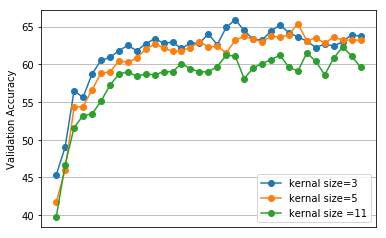

In [245]:
k_3=plt.plot(val_acc_epochs_CNN_1000, marker='o', label='kernal size=3')
k_5=plt.plot(val_acc_epochs_CNN_1000_5, marker='o', label='kernal size=5')
k_11=plt.plot(val_acc_epochs_CNN_1000_11, marker='o', label='kernal size =11')



plt.legend()
plt.xticks([])
plt.grid()
plt.ylabel('Validation Accuracy')
